# 1. 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from kiwipiepy import Kiwi
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

## 1) 데이터 로드하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x23f1e9c8888>)

In [3]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data.head(5)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [8]:
total_data['label']  = total_data['ratings'].apply(lambda x : 1 if x>=4 else 0)

In [14]:
len(total_data),total_data['reviews'].nunique()

(200000, 199908)

- 중복 데이터가 92개 존재하므로 제거해준다.

In [17]:
total_data = total_data.drop_duplicates(subset=['reviews']).reset_index(drop = True)

In [20]:
total_data.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

- 결측값은 존재하지 않는다.

## 2) 훈련 데이터와 테스트 데이터 분리하기

In [36]:
X_train,X_test= train_test_split(total_data,test_size=0.25,stratify=total_data['label'],random_state=42)

## 3) 레이블 분포 확인하기

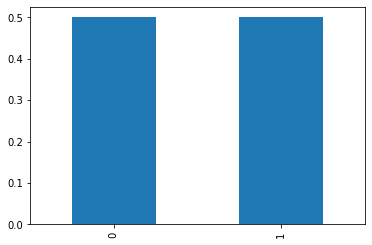

In [39]:
total_data['label'].value_counts(normalize = True).plot.bar()
plt.show()

In [40]:
X_train['label'].value_counts()

0    74966
1    74965
Name: label, dtype: int64

In [41]:
X_test['label'].value_counts()

0    24989
1    24988
Name: label, dtype: int64

- train & test 레이블 분포가 고르게 잘 나누어졌다.

## 4) 데이터 정제하기

- 정규표현식을 통해 한글, 띄어쓰기를 제외하고 제거

In [45]:
X_train['reviews'] = X_train['reviews'].str.replace('[^ ㄱ-ㅎㅏ-ㅣ가-힣]','')

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
X_train['reviews'].replace('',np.nan,inplace = True)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [52]:
X_train.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [63]:
X_train = X_train.reset_index(drop = True)

In [64]:
X_train.shape

(149931, 3)

- 결측값은 존재하지 않았다.
- test 데이터도 적용

In [56]:
X_test['reviews'] = X_test['reviews'].str.replace('[^ ㄱ-ㅎㅏ-ㅣ가-힣]','')
X_test['reviews'].replace('',np.nan,inplace = True)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method

In [57]:
X_test.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

- X_test에도 결측값은 존재하지 않았다.

In [59]:
X_test =X_test.reset_index(drop = True)

In [61]:
X_test.shape

(49977, 3)

## 5) 토큰화

In [80]:
okt = Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [83]:
X_train['tokenizer'] = X_train['reviews'].apply(okt.morphs)
X_train['tokenizer'] = X_train['tokenizer'].apply(lambda x: [item for item in x if item not in stopwords])
X_test['tokenizer'] = X_test['reviews'].apply(okt.morphs)
X_test['tokenizer'] = X_test['tokenizer'].apply(lambda x: [item for item in x if item not in stopwords])

In [84]:
X_train.head()

,ratings,reviews,label,tokenizer
0,2,택배사 좀 바꾸셔야겠어요당일 발송제품이 주일만에 오네요 지역도 서울인데,0,"[택배, 사, 좀, 바꾸셔야겠어요, 당일, 발송, 제품, 주일, 만에, 오네요, 지..."
1,5,아이가 사달라고해서 생선으로 구입했습니다 근뎅뭔 맛인지는ㅡㅡㅋㅋ,1,"[아이, 사, 달라, 고해, 서, 생선, 으로, 구입, 했습니다, 근, 뎅, 뭔, ..."
2,5,이유식용으로 구매했어요 딱 생각했던 사이즈에요 평소에 작은 사이즈 도마가 편해서 자...,1,"[이유, 식용, 으로, 구매, 했어요, 딱, 생각, 했던, 사이즈, 에요, 평소, ..."
3,2,배송이 이렇게 왔네요ㄷㄷ 다시 펴지지도 않는다는점 구매평도 남겼지만 반품귀찮아 그냥...,0,"[배송, 이렇게, 왔네요, ㄷㄷ, 다시, 펴지지도, 않는다는, 점, 구, 매, 평,..."
4,1,고객을 생각하지도 않는 업체인것 같네요 과실로 인해서 고객이 불편을 느끼는데 사과한...,0,"[고객, 생각, 하지도, 않는, 업체, 것, 같네요, 과실, 로, 인해서, 고객, ..."


In [85]:
X_test.head()

,ratings,reviews,label,tokenizer
0,5,간편한거찾다가 사봤어요,1,"[간편한거, 찾다가, 사봤어요]"
1,5,항상 쓰던거라 주문합니다,1,"[항상, 쓰던거라, 주문, 합니다]"
2,5,맘에 들어요 서비스로 주신 머리핀도 이쁘네요,1,"[맘, 들어요, 서비스, 로, 주신, 머리핀, 이쁘네요]"
3,1,간단히 말해서 정품이 아닌거 같네요 음질 모노밖에 안됩니다 그냥 삼성사이트에서 제값...,0,"[간단히, 말, 해서, 정품, 아닌거, 같네요, 음질, 모노, 밖에, 안됩니다, 그..."
4,2,저만그럴수있지만 앞뒤구분이 너무 힘들고 수분기는 앞뒤를 피부를 닦을정도는 아니예요 ...,0,"[저, 만, 그럴수있지만, 앞뒤, 구분, 너무, 힘들고, 수, 분기, 앞뒤, 피부,..."


## 6) 단어와 길이 분포 확인하기

### Train data의 긍부정 단어들의 빈도수와 길이 파악

In [93]:
negative_words = np.hstack(X_train.loc[X_train['label']==0]['tokenizer'].values)
positive_words = np.hstack(X_train.loc[X_train['label']==1]['tokenizer'].values)

In [97]:
negative_count = Counter(negative_words)
positive_count = Counter(positive_words)

In [102]:
negative_count.most_common(20)

[('너무', 13063),
 ('요', 11842),
 ('안', 11741),
 ('배송', 9154),
 ('그냥', 8522),
 ('잘', 7776),
 ('로', 5749),
 ('했는데', 5680),
 ('별로', 5582),
 ('못', 5101),
 ('제품', 5007),
 ('으로', 4994),
 ('좀', 4921),
 ('생각', 4918),
 ('ㅠㅠ', 4869),
 ('사용', 4841),
 ('하고', 4714),
 ('보다', 4634),
 ('구매', 4576),
 ('맛', 3984)]

- 못,별로, ㅠㅠ 보다 등 부정적인 단어들이 주로 사용

In [103]:
positive_count.most_common(20)

[('잘', 15300),
 ('좋아요', 14303),
 ('배송', 12248),
 ('너무', 9122),
 ('재구매', 8665),
 ('구매', 7111),
 ('요', 6642),
 ('사용', 5418),
 ('가격', 5053),
 ('으로', 4430),
 ('로', 4416),
 ('같아요', 4414),
 ('좋네요', 4203),
 ('보다', 3999),
 ('빠르고', 3938),
 ('제품', 3937),
 ('주문', 3782),
 ('입니다', 3722),
 ('생각', 3500),
 ('더', 3341)]

- 잘, 좋아요, 재구매, 좋네요, 더 등 긍정적인 단어들이 주로 사용

In [129]:
np.mean(X_train.loc[X_train['label']==0]['tokenizer'].map(lambda x : len(x)).values)

14.10734199503775

Negative의 평균 : 14.10734199503775
Positive의 평균 : 10.780444207296739


<Figure size 432x288 with 0 Axes>

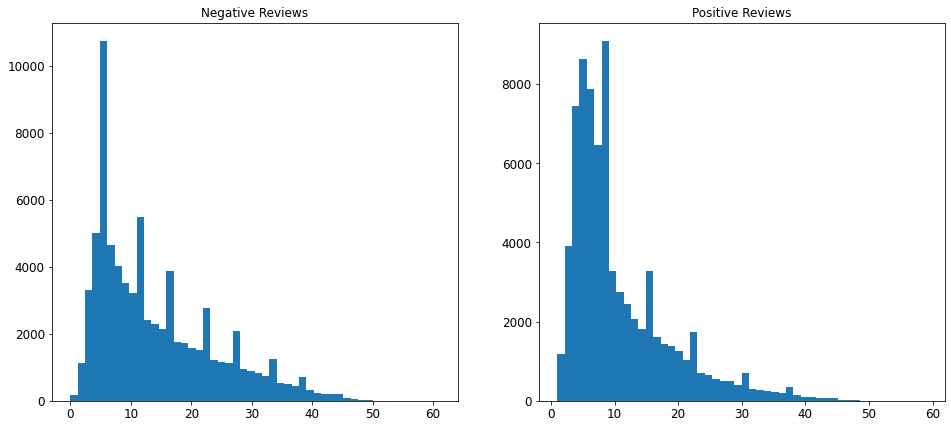

In [130]:
title_list =['Negative','Positive']

import seaborn as sns

i = 0
plt.figure()
fig,ax = plt.subplots(1,2,figsize = (16,6))
for value in X_train['label'].unique() :
    i+=1
    plt.subplot(1,2,i)
    plt.title(f'{title_list[value]} Reviews')
    df = X_train.loc[X_train['label']==value]['tokenizer'].map(lambda x : len(x)).values
    plt.hist(df,bins=50)
    locs,labels = plt.xticks()
    plt.subplots_adjust(hspace =.6, top = 1)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
    print(f"{title_list[value]}의 평균 : {np.mean(df)}")
plt.show()


- 부정리뷰가 긍정리뷰보다 평균적으로 길게 쓰임을 알 수 있다.

In [132]:
X_tr = X_train['tokenizer'].values
y_tr = X_train['label'].values

X_te = X_test['tokenizer'].values
y_te = X_test['label'].values

## 7) 정수 인코딩

In [134]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_tr)

In [136]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94707
등장 빈도가 1번 이하인 희귀 단어의 수: 52660
단어 집합에서 희귀 단어의 비율: 55.603070522770224
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.822492251009928


In [137]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42049


In [139]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_tr)
X_tr = tokenizer.texts_to_sequences(X_tr)
X_te = tokenizer.texts_to_sequences(X_te)

- 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [140]:
X_tr

[[163, 188, 21, 1, 1819, 926, 14, 1820, 309, 1675, 4338, 7656, 52],
 [73, 188, 337, 1259, 38, 3433, 12, 68, 133, 1894, 4006, 1212, 24, 864, 1],
 [610,
  6971,
  12,
  9,
  44,
  72,
  18,
  637,
  34,
  105,
  888,
  350,
  34,
  3257,
  1067,
  322,
  140,
  394,
  6579,
  30,
  814,
  1552,
  83,
  885,
  26,
  9,
  19,
  1062,
  106,
  2162,
  3735,
  271,
  6397,
  78,
  1770,
  132,
  149,
  177,
  18,
  17,
  24081,
  495,
  208,
  5409,
  6],
 [4,
  248,
  156,
  5303,
  95,
  7913,
  13646,
  278,
  101,
  215,
  663,
  16233,
  69,
  933,
  13,
  1048,
  1471,
  37,
  9,
  1026,
  10,
  39],
 [892,
  18,
  2990,
  1116,
  768,
  31,
  180,
  7914,
  11,
  13647,
  892,
  1160,
  20516,
  2036,
  3150,
  7,
  19,
  194,
  248,
  4654,
  1,
  1,
  6232],
 [299, 4, 100, 744],
 [174,
  816,
  10616,
  1,
  3626,
  23,
  5004,
  128,
  41,
  32,
  82,
  4,
  10113,
  268,
  4,
  1068,
  1,
  865,
  1485,
  199,
  1638,
  11,
  48,
  1414,
  37,
  634,
  13,
  3786,
  1,
  7424,
  2

## 8) 패딩

리뷰의 최대 길이 : 61
리뷰의 평균 길이 : 2.6678938978596822e-05


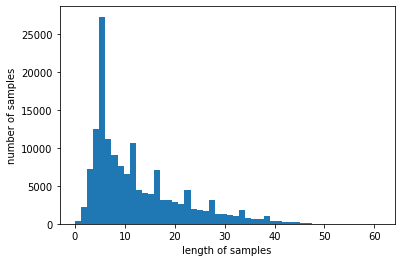

In [142]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_tr))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_tr))
plt.hist([len(s) for s in X_tr], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [144]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [145]:
max_len = 80
below_threshold_len(max_len, X_tr)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [146]:
X_train = pad_sequences(X_tr, maxlen = max_len)
X_test = pad_sequences(X_te, maxlen = max_len)

In [147]:
X_train

array([[   0,    0,    0, ..., 4338, 7656,   52],
       [   0,    0,    0, ...,   24,  864,    1],
       [   0,    0,    0, ...,  208, 5409,    6],
       ...,
       [   0,    0,    0, ...,   16,  102,  921],
       [   0,    0,    0, ..., 4293, 1232,   39],
       [   0,    0,    0, ...,   10,   19,  168]])

# 3. GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [148]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [150]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [151]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [153]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_tr, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 45s 20ms/step - loss: 0.2777 - acc: 0.8948 - val_loss: 0.2441 - val_acc: 0.9070

Epoch 00001: val_acc improved from -inf to 0.90699, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 41s 21ms/step - loss: 0.2193 - acc: 0.9202 - val_loss: 0.2392 - val_acc: 0.9106

Epoch 00002: val_acc improved from 0.90699 to 0.91063, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 42s 21ms/step - loss: 0.1998 - acc: 0.9293 - val_loss: 0.2302 - val_acc: 0.9155

Epoch 00003: val_acc improved from 0.91063 to 0.91550, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 43s 22ms/step - loss: 0.1845 - acc: 0.9347 - val_loss: 0.2248 - val_acc: 0.9171

Epoch 00004: val_acc improved from 0.91550 to 0.91713, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 44s 22ms/step - loss: 0.1728 - acc: 0.9398 - val_loss: 0.23

In [154]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_te)[1]))

1562/1562 [==============================] - 7s 5ms/step - loss: 0.2192 - acc: 0.9195

 테스트 정확도: 0.9195


# 4. 리뷰 예측해보기

In [157]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [158]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.39% 확률로 긍정 리뷰입니다.


In [159]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

98.87% 확률로 부정 리뷰입니다.
